# Run Q3Dfit from this Jupyter Notebook in a suitable environment.

<h3><font color='teal'>Installation of the environment and the package are described <a href="https://q3dfit.readthedocs.io/">here</a>. </font></h3>

This Jupyter notebook allows you to run Q3Dfit, a PSF decomposition and spectral analysis package tailored for JWST NIRSpec and MIRI IFU observations. 

Q3Dfit is developed as a science-enabling data product by the Early Release Science Team #1335 Q3D. You can find more information about this ERS program **Q3D** [here](https://wwwstaff.ari.uni-heidelberg.de/dwylezalek/q3d.html) and [here](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1335).

The software is based on the existing package IFSFIT developed by Dave Rupke (see [ADS link](https://ui.adsabs.harvard.edu/abs/2017ApJ...850...40R/abstract)).

The following notebook will guide you through the initialization procedure and will then perform the analysis. 

## Table of Contents

* [1. Initialization](#chapter1)
    * [1.1. Setting up the directory tree](#chapter1_1)
    * [1.2. Setting up the fitting parameters](#chapter1_2)        
* [2. Run Q3Dfit](#chapter2)
* [3. Run plotting script (q3da)](#chapter3)


## 1. Initialization <a class="anchor" id="chapter1"></a>

In [1]:
# unless you are running this python notebook from the directory where q3dfit is installed, you need to point the
# path to the package in order to import it. 
import sys
# add path to the installation directory
sys.path.append("/Users/nadia/mypython")
import q3dfit

In [2]:
import os.path
import numpy as np
from q3dfit.common.questfit_readcf import readcf

In [3]:
# Convenience function
# Ref: https://github.com/spacetelescope/jwebbinar_prep/blob/main/imaging_mode/imaging_mode_stage_1.ipynb
from astropy.utils.data import download_file
def download_files(files, output_directory, force=False):
    """Given a tuple or list of tuples containing (URL, filename),
    download the given files into the current working directory.
    Downloading is done via astropy's download_file. A symbolic link
    is created in the specified output dirctory that points to the
    downloaded file.
    
    Parameters
    ----------
    files : tuple or list of tuples
        Each 2-tuple should contain (URL, filename), where
        URL is the URL from which to download the file, and
        filename will be the name of the symlink pointing to
        the downloaded file.
        
    output_directory : str
        Name of the directory in which to create the symbolic
        links to the downloaded files
        
    force : bool
        If True, the file will be downloaded regarless of whether
        it is already present or not.
                
    Returns
    -------
    filenames : list
        List of filenames corresponding to the symbolic links
        of the downloaded files
    """
    # In the case of a single input tuple, make it a
    # 1 element list, for consistency.
    filenames = []
    if isinstance(files, tuple):
        files = [files]
        
    for file in files:
        filenames.append(file[1])
        if force:
            print('Downloading {}...'.format(file[1]))
            demo_file = download_file(file[0], cache='update')
            # Make a symbolic link using a local name for convenience
            if not os.path.islink(os.path.join(output_directory, file[1])):
                os.symlink(demo_file, os.path.join(output_directory, file[1]))
        else:
            if not os.path.isfile(os.path.join(output_directory, file[1])):
                print('Downloading {}...'.format(file[1]))
                demo_file = download_file(file[0], cache=True)
                # Make a symbolic link using a local name for convenience
                os.symlink(demo_file, os.path.join(output_directory, file[1]))
            else:
                print('{} already exists, skipping download...'.format(file[1]))
                continue
    return filenames    

### 1.1. Setting up the directory tree <a class="anchor" id="chapter1_1"></a>

Define the directories in which your data cube(s) that you want to analyse are stored and the output directories. We recommend creating a working directory that you name after your target, in which all outputs from Q3Dfit will be saved. 

In [4]:
# Input/Output directories/files
indir = './test_Spitzer_MIR/'
if not os.path.exists(indir):
    os.makedirs(indir)
outdir = indir
if not os.path.exists(outdir):
    os.makedirs(outdir)
logfile = outdir+'test_questfit_fitlog.txt'
path_to_npy_file = outdir # path for initproc.npy

# Input files
infile = indir+'22128896_mock_cube.fits'
cfinfile = indir+'22128896.cf'

Download data from public Box folder:

In [5]:
# make tuples of urls and download filenames
# infile = 1x1 mock data cube: containing only 1 single spaxel with a Spitzer spectrum
infile_tup = ('https://rhodes.box.com/shared/static/spe9pc4kbwylw2khwcca0cimoaks6puh.fits', '22128896_mock_cube.fits')
# config file
cf_tup = ('https://rhodes.box.com/shared/static/bpiqbmjbmcgbyj5kmbd1zybmjiierarh.cf', '22128896.cf')
# download files; by default don't force overwrite and take first element of output
infile = download_files(infile_tup, indir, force=False)[0]
cfinfile = download_files(cf_tup, indir, force=False)[0]
infile = indir+infile
cfinfile = indir+cfinfile

22128896_mock_cube.fits already exists, skipping download...
22128896.cf already exists, skipping download...




Some general information about your cube:

In [6]:
ncols = 1 # number of columns
nrows = 1 # number of rows
platescale = 0.3

fitrange = np.array([5.422479152679443, 29.980998992919922])  # micron

if not os.path.isfile(infile): 
    print('Data cube not found.')
if not os.path.isfile(cfinfile):
    print('Configuration file not found.')
else:
    config_file = readcf(cfinfile)

In [7]:
dict_argsreadcube = {'waveunit_in': 'Angstrom',
                    'fluxunit_in': 'Jy'}
wmapext = None
wavext = 4
zerodq = True   # put all dq to good (0)

### 1.2. Setting up the fitting parameters <a class="anchor" id="chapter1_2"></a>

What lines do you want to fit? You can choose from the linelists in q3dfit/data/linelists/*.

In [8]:
lines = ['H2_00_S5', '[ArII]6.99', '[ArIII]8.99', '[NeII]12.81', 
         '[NeIII]15.56', 'H2_00_S3', 'H2_00_S1', '[SIII]18.71']

How many components do you want to be fitted to the emission lines?

In [9]:
maxncomp = 1

In [10]:
# Initialize line ties, n_comps, z_inits, and sig_inits.
linetie = dict()
ncomp = dict()
zinit_gas = dict()
siginit_gas = dict()
for i in lines:
    linetie[i] = '[NeII]12.81'
    ncomp[i] = np.full((ncols,nrows),maxncomp)
    zinit_gas[i] = np.full((ncols,nrows,maxncomp),0.)
    siginit_gas[i] = np.full(maxncomp, 1000.) #0.1) #1000.)
    zinit_stars=np.full((ncols,nrows),0.0)
siginit_stars = 100
maskwidths_def = 2000 # half-width in km/s for emission line masking during the continuum fit

In [11]:
zsys_gas = 0.0
siglim_gas = np.array([5., 4000.])

For a description of continuum fitting parameters in the .cf file, please see the documentation: 
https://q3dfit.readthedocs.io/en/latest/

In [12]:
fcncontfit = 'questfit'
argscontfit = dict()
argscontfit['config_file'] = cfinfile
argscontfit['models_dictionary'] = {}
argscontfit['template_dictionary'] = {}
argscontfit['outdir'] = outdir

For a description of continuum fitting parameters in the .cf file, please see the documentation: 
https://q3dfit.readthedocs.io/en/latest/

#### 1.2.4. Wavelength-dependent spectral convolution <a class="anchor" id="chapter1_2_4"></a>
If no convolution is desired, then set `spectres_convolve` to None.  
If convolution is desired, then `spectres_convolve` and `spect_instrum` are required. 
Specify the desired convolution method as the dictionary key, which should mirror the filename in /data/dispersion_files, and the dictionary elements should specify the grating, spectral resolution, or velocity.

e.g. to convolve spectrum with JWST NIRSPEC / G140M, then set `spect_instrum = {'JWST_NIRSPEC':['G140M']}`

In [13]:
spect_instrum = {'flat':['R4666']}
spectres_convolve = None
#spectres_convolve = {'ws_instrum':spect_instrum}

One dictionary must be defined for a line plot to appear. `argspltlin1` holds the options for the first line plot, and `argspltlin2` is for the second. Parameter options are fed in as keyword/data pairs.

Required keywords in each dictionary:
* `nx`: Number of subplots in the horizontal direction
* `ny`: Number of subplots in the vertical direction
* Options for centerting the plot:
    - `line`: a string list of line labels
    - `center_obs`: a float list of wavelengths of each subplot center, in the observed (plotted) frame
    - `center_rest`: a float list of wavelengths of each subplot center, in the rest frame, which are converted to obs. frame

Optional keywords:
* `size`: float list of widths in wavelength space of each subplot; if not specified, default is 300 $Å$
* `IR`: set to `True` to use infrared-style plot

In [14]:
argspltlin1 = {'nx': 3,
               'ny': 2,
               'line': ['[ArII]6.99', '[ArIII]8.99', '[NeII]12.81', 
                        '[NeIII]15.56', 'H2_00_S1', '[SIII]18.71'],
               'size': [3., 3., 3., 3., 3., 3.],
               'IR': True}

The following cell will create the initialisation structure. **Do not change anything in this cell.** 

In [15]:
initproc = { \
            # Required pars
            'fcninitpar': 'parinit',
            'fitran': fitrange,
            'infile': infile,
            'label': config_file['source'][0].replace('.ideos','').replace('.npy', ''),
            'lines': lines,
            'linetie': linetie,
            'maxncomp': maxncomp,
            'ncomp': ncomp,
            'outdir': outdir,
            'zinit_stars': zinit_stars,
            'zinit_gas': zinit_gas,
            'zsys_gas': zsys_gas,
            # Optional pars
            'spect_convol':spectres_convolve,
            'fcncontfit': fcncontfit,            
            'argscontfit': argscontfit,
            'argspltlin1': argspltlin1,
            'fcncheckcomp': 'checkcomp',
            'maskwidths_def': maskwidths_def,
            'logfile': logfile,
            'siglim_gas': siglim_gas,
            'siginit_gas': siginit_gas,
            'siginit_stars': siginit_stars,
            'zerodq': zerodq,
            'argsreadcube': dict_argsreadcube,
            'wmapext': wmapext,
            'wavext': wavext,
            'plotMIR': True
           }

If you want to run `q3dfit` in batch mode, run this cell, which saves initproc to an `npy` file. In your python command line, read in that `npy` file with
<pre><code>import numpy as np
initproc = np.load('path/to/the/npy/file/initproc.npy',allow_pickle=True)</code></pre>
and then run `q3dfit` with 
<pre><code>from q3dfit.common.q3df
import q3df q3df(initproc[()],cols=cols,rows=rows)</code></pre>

In [16]:
initproc_npy = 'initproc.npy'
np.save(path_to_npy_file+initproc_npy,initproc)

## 2. Run Q3Dfit <a class="anchor" id="chapter2"></a>

In [17]:
# This may be unique to the user, insert your path to the q3dfit/ folder here
import sys
if '../../' not in sys.path:
    sys.path.append('../../')

from q3dfit.common.q3df import q3df
from q3dfit.common.q3da import q3da

In [18]:
cols = [1]
rows = [1]

In [19]:
q3df(initproc, cols=cols, rows=rows, quiet=False)

FITLOOP: First call to FITSPEC
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.02023400 +/- 2.5127e-04 (1.24%) (init = 0.1)
    blackbody500a:         0.00137735 +/- 1.9546e-04 (14.19%) (init = 0.1)
    blackbody500T:         279.419345 +/- 8.11906561 (2.91%) (init = 500)
    blackbody500_ext_Av:   0.85467785 +/- 0.15141491 (17.72%) (init = 0)
    blackbody500_abs_tau:  0.71293644 +/- 0.24422912 (34.26%) (init = 0)
    blackbody50a:          0.00868952 +/- 0.00364542 (41.95%) (init = 0.1)
    blackbody50T:          104.622482 +/- 3.57455989 (3.42%) (init = 50)
    blackbody50_ext_Av:    2.4727e-18 +/- 0.31112261 (12582452664609781760.00%) (init = 0)
    blackbody50_abs_tau:   1.4344e-24 +/- 128.999104 (8993079356353537478899007488.00%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(blackbody50a, blackbody50_ext_Av)          = -1.000
    C(blackbody500a, blackbody500_ext_Av)        = -0.973
    C(blackbody50T, blackbody50_ext_Av)          =  0.948
   

## 3. Run plotting script (q3da) <a class="anchor" id="chapter3"></a>

CUBE: No wavelength units in header; assuming micron.
CUBE: No flux units in header; assuming MJy/sr
Column 1 of 1
    Row 1 of 1


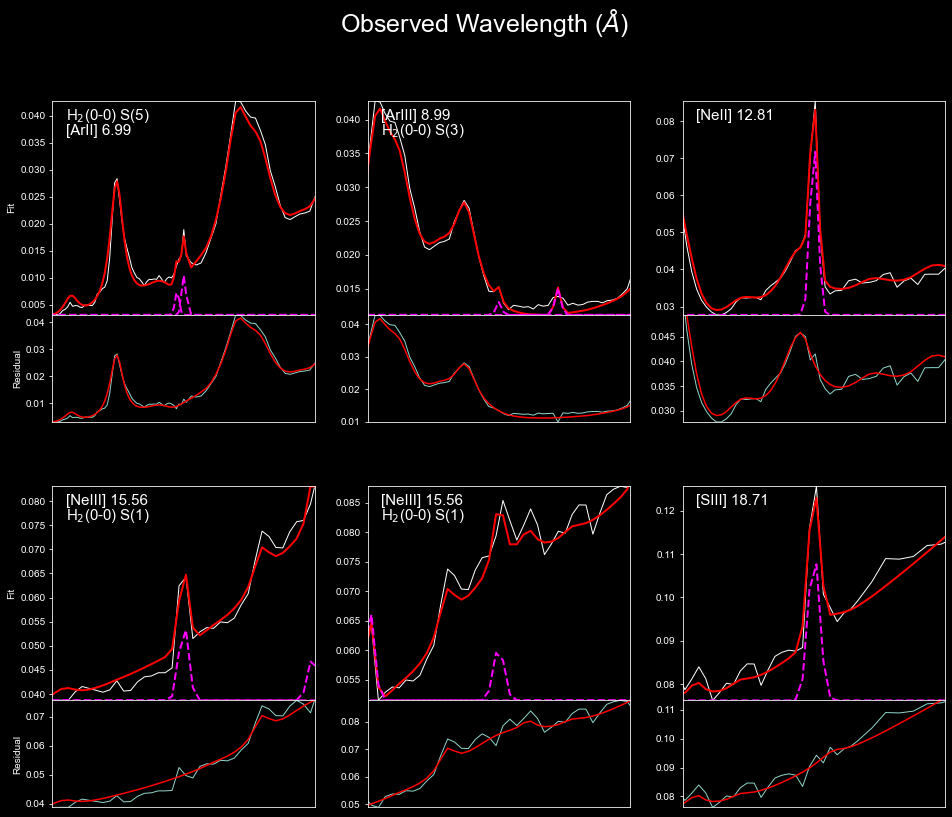

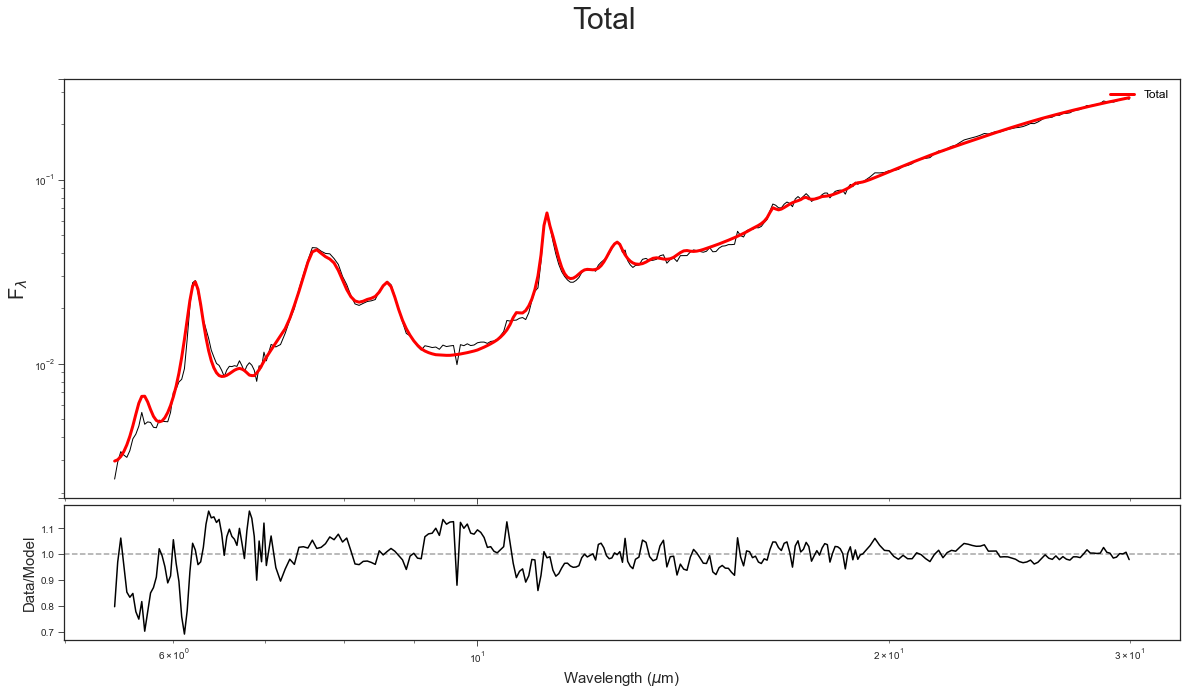

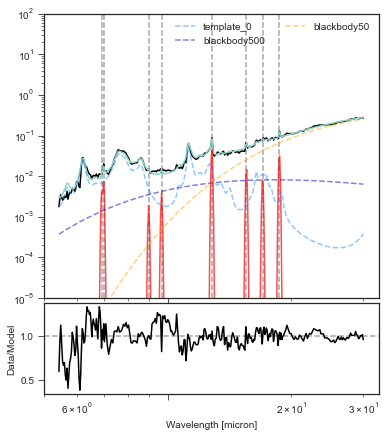

In [20]:
%matplotlib inline
q3da(initproc, cols=cols, rows=rows, quiet=False)